<a href="https://colab.research.google.com/github/revanks/Xeeva_Task_Files/blob/main/Task_1_BERT_Multiclass_Text_Classifier_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Task - 1.	Text classification using BERT  </center>

In [1]:
!nvidia-smi

Fri Nov 12 09:53:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## In this task to classify the text we fine tune the pre trained BERT model 

In [2]:
from google.colab import files
data=files.upload()

Saving bert_sample.xlsx to bert_sample.xlsx


In [3]:
import pandas as pd
import numpy as np
data=pd.read_excel('bert_sample.xlsx')
data=pd.DataFrame(data)
data.head()

,ITEM_NAME,CATEGORY_ID
0,CALIBRACION TRANSDUCER 75 nm,CAPITAL ASSEMBLY
1,for pusher whskey,CAPITAL ASSEMBLY
2,Stat 40B Press Head Cup to Carrier from Stati...,CAPITAL ASSEMBLY
3,TRANSD. Cable (4145097103) scrw,CAPITAL ASSEMBLY
4,"ZT200 7,5BAR,13BAR60HZ NUMERO DE SERIE: AIF09...",CAPITAL ASSEMBLY


In [4]:
!pip install transformers --quiet

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 34.8 MB/s 
     |████████████████████████████████| 59 kB 6.7 MB/s 
     |████████████████████████████████| 596 kB 41.7 MB/s 
     |████████████████████████████████| 895 kB 38.5 MB/s 


In [5]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import shutil
import sys   

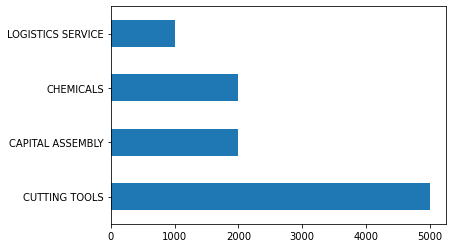

In [6]:
data['CATEGORY_ID'].value_counts().plot(kind="barh");

##Imputing dummy variable for categorical data ##
#### we have 4 classes to classify, we use dummy variable

In [7]:
X=data['ITEM_NAME']
Y=pd.get_dummies(data['CATEGORY_ID'])
df=pd.concat([X, Y], axis=1)
df

,ITEM_NAME,CAPITAL ASSEMBLY,CHEMICALS,CUTTING TOOLS,LOGISTICS SERVICE
0,CALIBRACION TRANSDUCER 75 nm,1,0,0,0
1,for pusher whskey,1,0,0,0
2,Stat 40B Press Head Cup to Carrier from Stati...,1,0,0,0
3,TRANSD. Cable (4145097103) scrw,1,0,0,0
4,"ZT200 7,5BAR,13BAR60HZ NUMERO DE SERIE: AIF09...",1,0,0,0
...,...,...,...,...,...
9995,Export Freight charges By Road,0,0,0,1
9996,EXPORT PACKING,0,0,0,1
9997,Express Delivery Charges,0,0,0,1
9998,Express Delivery Charges for PMF to CHMF Despa...,0,0,0,1


In [8]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.1)
train_df.shape, test_df.shape

((9000, 5), (1000, 5))

In [9]:
test_df['ITEM_NAME'][:1]

6744    015-247103 TORX IP9 FLAG HANDLE SCREWDRIVER KN...
Name: ITEM_NAME, dtype: object

In [10]:
train_df.head()

,ITEM_NAME,CAPITAL ASSEMBLY,CHEMICALS,CUTTING TOOLS,LOGISTICS SERVICE
8243,1/4 CARBIDE DRILL,0,0,1,0
8746,1344 Ingersoil master storage box No.M1801-12-...,0,0,1,0
5036,015-233012B INSERT COROTURN 111 CPMT 3(2.5)1-P...,0,0,1,0
4967,015-2299-35 SPOT CHECK KIT ERVIN 2 299 35,0,0,1,0
1971,fill all pot holes,1,0,0,0


In [11]:
train_df.columns

Index(['ITEM_NAME', 'CAPITAL ASSEMBLY', 'CHEMICALS', 'CUTTING TOOLS',
       'LOGISTICS SERVICE'],
      dtype='object')

In [12]:
# rearranging columns
train_df = train_df[['ITEM_NAME', 'CAPITAL ASSEMBLY', 'CHEMICALS', 'CUTTING TOOLS', 'LOGISTICS SERVICE']]

In [13]:
target_list = ['CAPITAL ASSEMBLY', 'CHEMICALS', 'CUTTING TOOLS', 'LOGISTICS SERVICE']

## Preprocessing the data

In [14]:
# hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 1e-05

In [15]:
from transformers import BertTokenizer, BertModel

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['ITEM_NAME']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }

In [18]:
train_size = 0.8
train_df = train_df.sample(frac=train_size, random_state=200).reset_index(drop=True)
val_df = train_df.drop(train_df.index).reset_index(drop=True)

In [19]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)

In [20]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [22]:
device

device(type='cuda')

In [23]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

## Building the BERT model 

In [24]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 4)
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [25]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [26]:
val_targets=[]
val_outputs=[]

In [27]:
def train_model(n_epochs, training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path):
   
  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf
   
 
  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)
    
    print('############# Epoch {}: Training End     #############'.format(epoch))
    
    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      #train_loss = train_loss/len(training_loader)
      #valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
      
      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
        # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))

  return model

In [28]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [29]:
ckpt_path = "/content/drive/MyDrive/curr_ckpt.ckpt"
best_model_path = "/content/drive/MyDrive/best_model.pt"

In [30]:
    import torch
    torch.cuda.empty_cache()

#Training for 5 eplochs

In [31]:
trained_model = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.312221 	Average Validation Loss: 0.000000
Validation loss decreased (inf --> 0.000000).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.153116 	Average Validation Loss: 0.000000
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epo

In [32]:
test_data=[]
for i in test_df['ITEM_NAME']:
    test_data.append(i)
#example

In [33]:
for i in test_data:
  print(i)

015-247103 TORX IP9 FLAG HANDLE SCREWDRIVER KN54NS-37048
A-T, AC-WT, AR98/02, C25-T, FG, N-T, O-K AND O-T TANKS - RENTAL IS PER DAY
01-24309246E DIAMOND GRIT 23.5387 23.5387
CHEVRON MEROPA 460 330 GAL TOTE
065508 - INSERTO - MFG: SANDVIK CORO | PN:390R-070208M 4240 - INSERTO INTERCAMBIAVEL 390R-070208M-PM 4240
015-247074RMREPAIR KM40TSS16FSDUPR07MAHER3955527
Cambio de termostato, tapón de radiador, bomba de agua, anticongelante, líquido de frenos y aceite de transmisión a unidad GSS7210
015-24703RM D24 DFR BODY 32 SHANK RH DRILL MAHER TOOLS 5175278
ALTRA R&O 32 - 330 GAL TOTE
015-2470116RCREBUILD KM40 BORING BARTHE BEST TOOLSBT-RCBBBHAC00024
1355 GT-50817_3 Ingersoil master
015-264-963 LUBRICANT SILVER GRADE ANTI-SEIZE HENKEL - LOCTITE CORP 76764
CHEMEX OF NI FC-7 275 GA TOTE
Drive shaft re-work
CHEVRON MEROPA 460 PUMP TO TANK  (275 GALLON TANK)
1 PVC CHECK
"SOCKET ADAPTER, 3/8"" FEMALE SQ, 1/2"" SQUARE"
015-234056SHIM .007IN STL 6INX18IN 10/PK BRANDED -PRECISION BRAND16AN7
015-247129 

## Evaluating model performance

In [34]:
#example='Express Delivery Charges with Dubble Driver'
for example in test_data:

  encodings = tokenizer.encode_plus(
      example,
      None,
      add_special_tokens=True,
      max_length=MAX_LEN,
      padding='max_length',
      return_token_type_ids=True,
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt'
  )
  model.eval()
  with torch.no_grad():
      input_ids = encodings['input_ids'].to(device, dtype=torch.long)
      attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
      token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
      output = model(input_ids, attention_mask, token_type_ids)
      final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
      print(train_df.columns[1:].to_list()[int(np.argmax(final_output, axis=1))])

CUTTING TOOLS
LOGISTICS SERVICE
CUTTING TOOLS
CHEMICALS
CUTTING TOOLS
CUTTING TOOLS
LOGISTICS SERVICE
CUTTING TOOLS
CHEMICALS
CUTTING TOOLS
CUTTING TOOLS
CUTTING TOOLS
CHEMICALS
LOGISTICS SERVICE
CHEMICALS
CUTTING TOOLS
CUTTING TOOLS
CUTTING TOOLS
CUTTING TOOLS
CAPITAL ASSEMBLY
CHEMICALS
CHEMICALS
CUTTING TOOLS
CHEMICALS
CUTTING TOOLS
CUTTING TOOLS
CUTTING TOOLS
CHEMICALS
CHEMICALS
CAPITAL ASSEMBLY
CUTTING TOOLS
CUTTING TOOLS
CHEMICALS
CUTTING TOOLS
CHEMICALS
CUTTING TOOLS
LOGISTICS SERVICE
CHEMICALS
CAPITAL ASSEMBLY
CUTTING TOOLS
CUTTING TOOLS
CUTTING TOOLS
LOGISTICS SERVICE
CUTTING TOOLS
CUTTING TOOLS
CUTTING TOOLS
CUTTING TOOLS
CHEMICALS
CHEMICALS
LOGISTICS SERVICE
CHEMICALS
CAPITAL ASSEMBLY
CUTTING TOOLS
CAPITAL ASSEMBLY
CUTTING TOOLS
CUTTING TOOLS
CUTTING TOOLS
CUTTING TOOLS
CUTTING TOOLS
CUTTING TOOLS
CHEMICALS
CUTTING TOOLS
CAPITAL ASSEMBLY
CAPITAL ASSEMBLY
CUTTING TOOLS
CHEMICALS
LOGISTICS SERVICE
CAPITAL ASSEMBLY
CAPITAL ASSEMBLY
CHEMICALS
LOGISTICS SERVICE
LOGISTICS SERVICE
C

In [35]:
y_test_pred=[]
for example in test_data:
  encodings = tokenizer.encode_plus(
      example,
      None,
      add_special_tokens=True,
      max_length=MAX_LEN,
      padding='max_length',
      return_token_type_ids=True,
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt'
  )
  model.eval()
  with torch.no_grad():
      input_ids = encodings['input_ids'].to(device, dtype=torch.long)
      attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
      token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
      output = model(input_ids, attention_mask, token_type_ids)
      final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
      #print(train_df.columns[1:].to_list()[int(np.argmax(final_output, axis=1))])
      #print([final_output])
      #print([int(np.argmax(final_output, axis=1))])
      result=[int(np.argmax(final_output, axis=1))]
      y_test_pred.append(result)


In [36]:
import numpy as np
array=np.array(test_df[['CAPITAL ASSEMBLY', 'CHEMICALS',	'CUTTING TOOLS','LOGISTICS SERVICE']])
y_test_true=np.argmax(array, axis=1)
len(array)

1000

In [37]:
from sklearn.metrics import accuracy_score
print("Accuracy of BERT is:",accuracy_score(y_test_true,y_test_pred))

Accuracy of BERT is: 0.928


In [38]:
from sklearn.metrics import classification_report
LABEL_COLUMNS=['CAPITAL ASSEMBLY', 'CHEMICALS',	'CUTTING TOOLS','LOGISTICS SERVICE']
print(classification_report(y_test_true,y_test_pred, target_names=LABEL_COLUMNS))

                   precision    recall  f1-score   support

 CAPITAL ASSEMBLY       0.87      0.94      0.90       207
        CHEMICALS       0.92      0.81      0.86       200
    CUTTING TOOLS       0.98      0.99      0.99       504
LOGISTICS SERVICE       0.78      0.84      0.81        89

         accuracy                           0.93      1000
        macro avg       0.89      0.89      0.89      1000
     weighted avg       0.93      0.93      0.93      1000

